In [1]:
using DrWatson
@quickactivate "Research"

In [51]:
using Statistics, LinearAlgebra, CoupledHMC, VecTargets, Plots
using CoupledHMC.AdvancedHMC
theme(:bright)

In [40]:
n_mc_max = 10_000
n_iters = 100
target = HighDimGaussian(2)

HighDimGaussian{VecTargets.BroadcastedNormalStd{Float64,Array{Float64,1},Array{Float64,1}}}(
bn: VecTargets.BroadcastedNormalStd{Float64,Array{Float64,1},Array{Float64,1}}(m=[0.0, 0.0], s=[1.0, 1.0])
)


In [41]:
function run_mcmc()
    alg = HMCSampler(rinit=rand, TS=MultinomialTS, ϵ=0.2, L=10)
    samples = sample(target, alg, n_iters)
    return mean(samples)
end

mean_ests = [run_mcmc() for _ in 1:n_mc_max]

;

In [42]:
using CoupledHMC: get_ahmc_primitives, sample

function sample_after_meeting(target, alg::CoupledHMCSampler, n_after_samples::Int; theta0=nothing, progress=false)
    rng, hamiltonian, proposal, theta0 = get_ahmc_primitives(target, alg, theta0)
    samples = sample_until_meeting(rng, hamiltonian, proposal, theta0)
    samples_after_meeting = sample(
        target, HMCSampler(rinit=alg.rinit, TS=alg.TS, ϵ=alg.ϵ, L=alg.L), n_after_samples; 
        theta0=samples[end][:,1], progress=progress
    )
    # Duplicate the `n_samples_left` part to make the dimension consistent
    samples_after_meeting = map(s -> cat(s, s; dims=2), samples_after_meeting)
    return cat(samples, samples_after_meeting; dims=1)
end

function run_coupled_mcmc()
    alg = CoupledHMCSampler(rinit=rand, TS=MultinomialTS, ϵ=0.2, L=10)
    samples = sample(target, alg, n_iters)
    τ = τ_of(samples)
    return H_of(x -> x, samples, 10, τ, n_iters)
end

mean_unbiased_ests = [run_coupled_mcmc() for _ in 1:n_mc_max]

;

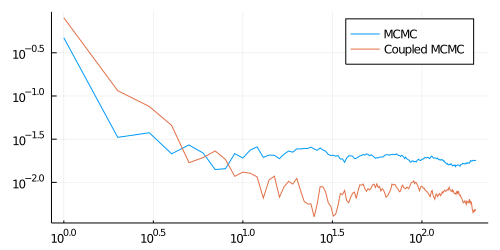

In [39]:
p = plot(; size=(500, 250), xscale=:log, yscale=:log)
plot!(p, [norm(mean(mean_ests[1:n_mc]))          for n_mc in 1:50:n_mc_max], label="MCMC")
plot!(p, [norm(mean(mean_unbiased_ests[1:n_mc])) for n_mc in 1:50:n_mc_max], label="Coupled MCMC")

In [59]:
p = plot(; size=(300, 200), ylims=(0, 0.1))
plot!(p, [norm(mean(mean_ests[1:n_mc]))          for n_mc in 1:10:n_mc_max], label="MCMC")
plot!(p, [norm(mean(mean_unbiased_ests[1:n_mc])) for n_mc in 1:10:n_mc_max], label="Coupled")
xlabel!("#parallel simulations")
ylabel!("RMSE")
savefig(p, "a.png")